In [1]:
import pandas as pd
import numpy as np
from os import path
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

The first thing that we need to do is import the csv file that contains all of our cleaned data.

In [2]:
#Get the CSV file with all of our data
clean_data = pd.read_csv('data/cleaned/schwartau/schwartau.csv', encoding='UTF-8')

Next we are going to 'normalize' our timestamps. In order to do this, we are going to take its distance (1 step = 15 minute increment) from January 1st at time 00:00:00 in year 2017. This will give us an easier scale to base time off of.

In [3]:
#Alter timestamp data to be normalized
timestamps = np.array([x/clean_data.shape[0] for x in range(clean_data['timestamp'].shape[0])])
#Get circular time data for extra feature
circular_timestamps = np.array([])
for stamp in clean_data['timestamp']:
    stamp = np.datetime64(stamp)
    seconds = stamp - np.datetime64('{}-01-01T00:00:00'.format(str(stamp.astype('datetime64[Y]').astype(int) + 1970)))
    minutes = seconds.item().total_seconds() / 60
    tick = minutes/15
    circular_timestamps = np.append(circular_timestamps, tick)

Here, we are going to create a numpy array to store our features in. Once our array is created, we are going to rotate the array by -90 degrees. This will result in rows with one entry from each column. Therefore, we are getting a list of features for every given timestamp. Then, we use Min Max Scaler to normalize our data between 0 and 1 without altering the distribution of the data.

In [4]:
#Create a numpy array to store our features in
X = np.array([
    clean_data['flow'].values,
    clean_data['temperature'].values,
    clean_data['arrivals'].values,
    clean_data['departures'].values,
    clean_data['weight'].values,
    clean_data['humidity'].values,
    circular_timestamps
])
#Rotate array so that each row is an entry of features from each attribute
X = np.rot90(X, k=-1)

#Normalize using Min Max Scaler
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Here, we will try to find an epsilon value for our DBSCAN model. Since this value represents the minimum distance needed for two points to be classified in the same cluster, we figured that we could take a high percentile of the distances in order to only classify non-normal behavior in the data. This non-normal behavior is what we are interested, but this method also allows us to cluster healtyh behavior together as one big cluster.

In [5]:
#Let's try to find a good epsilon value
neighbors = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(X)
distances = np.array([])
for x in X:
    distances = np.append(distances, [neighbors.kneighbors([x])[0][0][1]])
epsilon = np.percentile(distances, 99.99)
print(f'Try epsilon value {epsilon}')

Try epsilon value 0.12726291641576004


Now we build the model using the calculated epsilon and a min_sample size of 96. min_sample determines how many points must be clustered together to qualify as a cluster. We chose 96 since that would require a whole days worth of points needed to qualify as non-normal behavior. 

In [6]:
#Get model
model = DBSCAN(eps=epsilon, min_samples=96, n_jobs=None, metric='euclidean').fit(X)
#Get labels
labels = model.labels_
#Print number of clusters
clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'There are {clusters} cluster(s)')

There are 4 cluster(s)


Now, we graph each attribute by time.

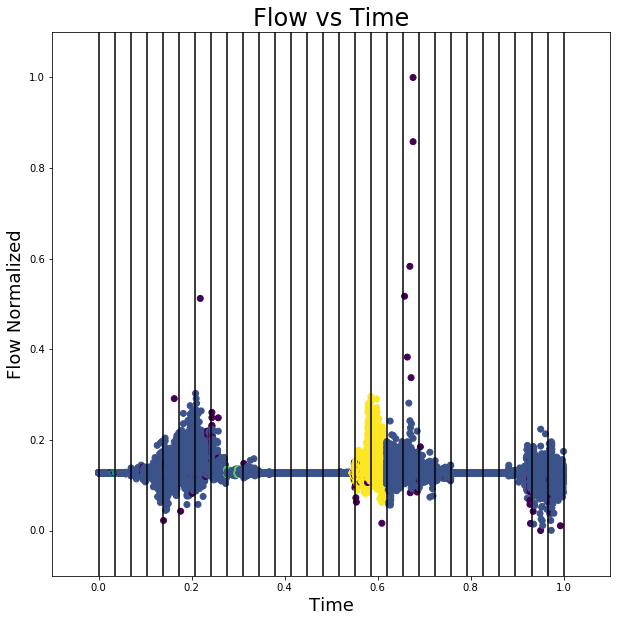

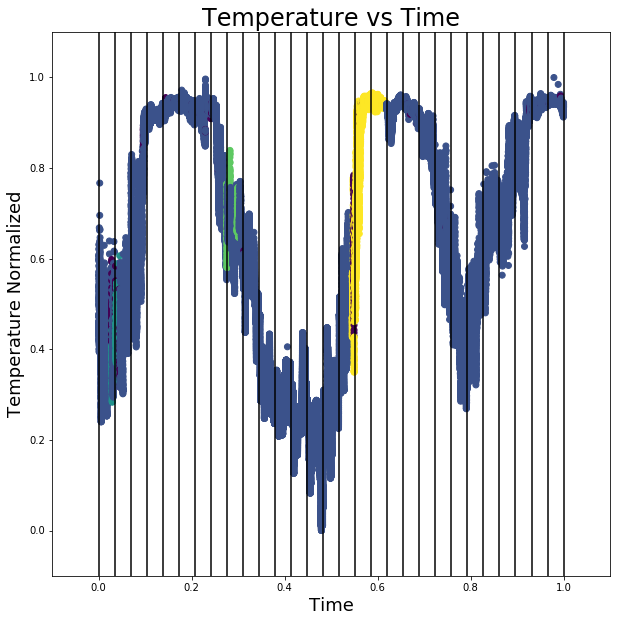

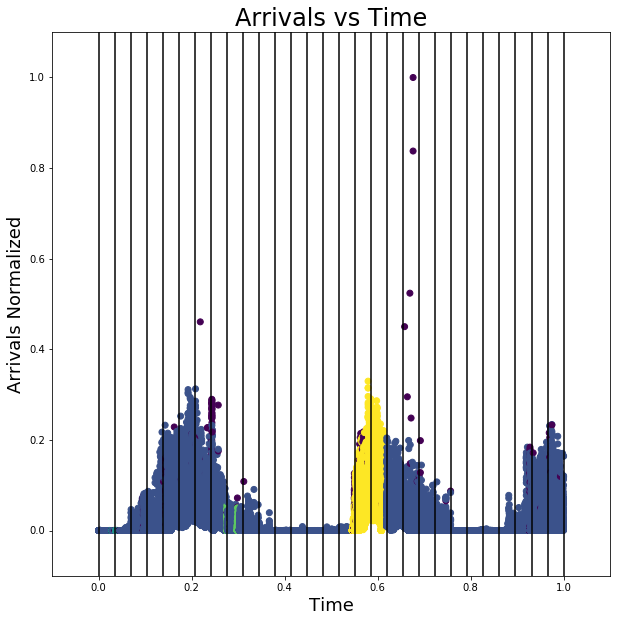

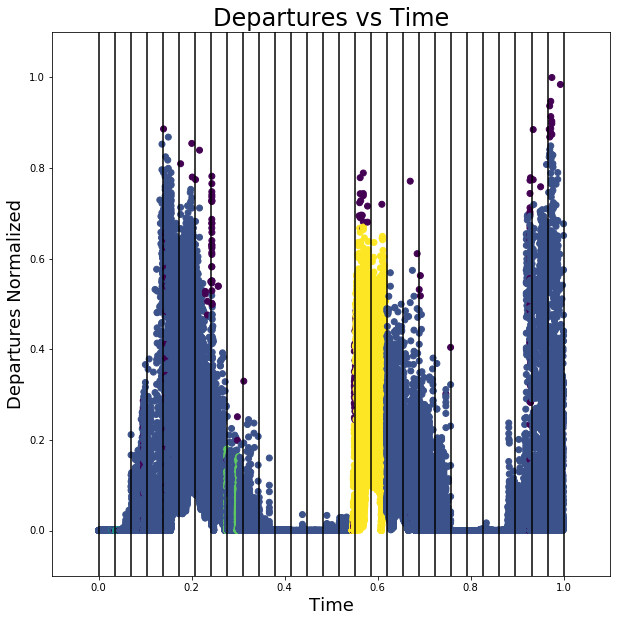

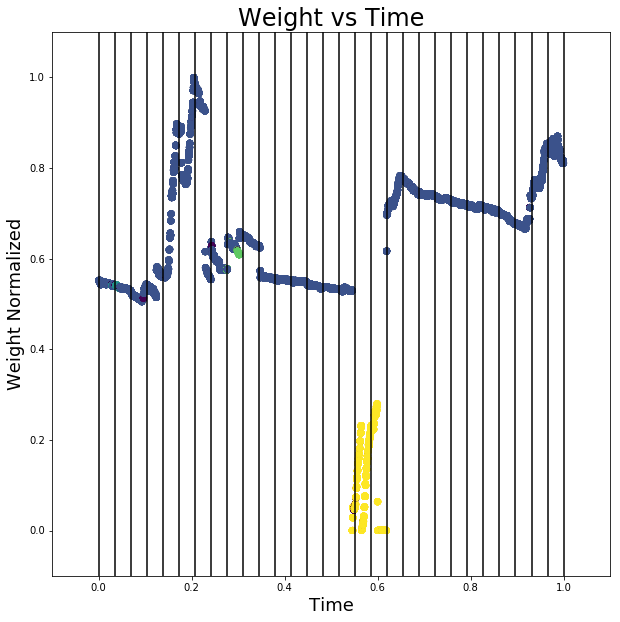

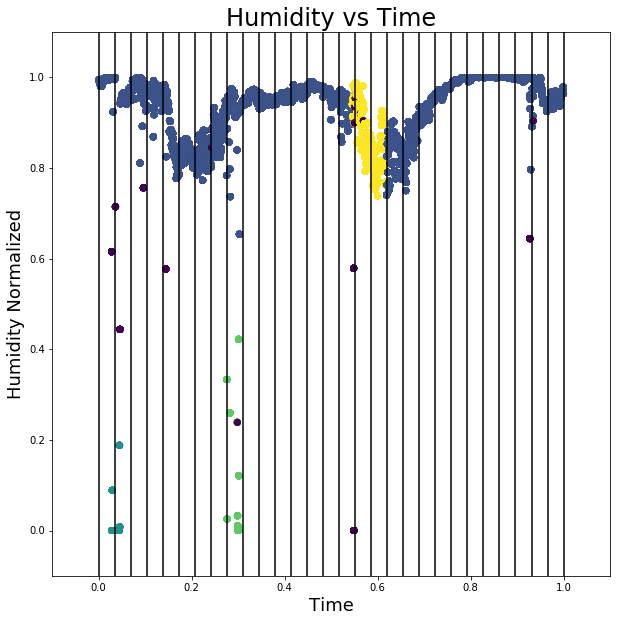

In [7]:
#Graph each attribute
for attribute, column in [['Flow', 6], ['Temperature', 5], ['Arrivals', 4], ['Departures', 3], ['Weight', 2], ['Humidity', 1]]:
    plt.figure(figsize=(10,10))
    plt.title(f'{attribute} vs Time', fontsize=24)
    plt.ylabel(f'{attribute} Normalized', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    for i in range(30):
        plt.axvline(x=i/29, c='black')
    plt.xlim(right=1.1)
    plt.xlim(left=-0.1)
    plt.ylim(top=1.1)
    plt.ylim(bottom=-0.1)
    plt.scatter(timestamps, X[:,column], c=labels)

Now we will graph each individual cluster by its label for each attribute by time. Note that lable -1 is outliers and label 0 is what we classify as normal behavior. We also classified label 4 as having the occurence of a harvest where honey was removed from the hive willingly.

C:\Users\svand\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


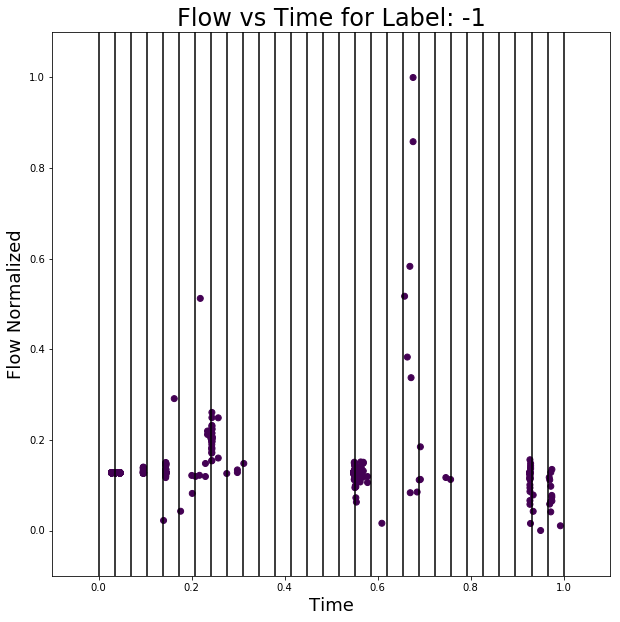

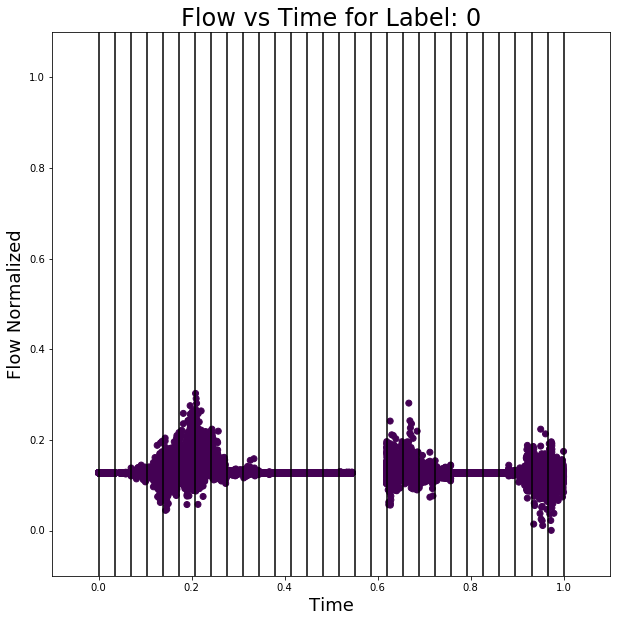

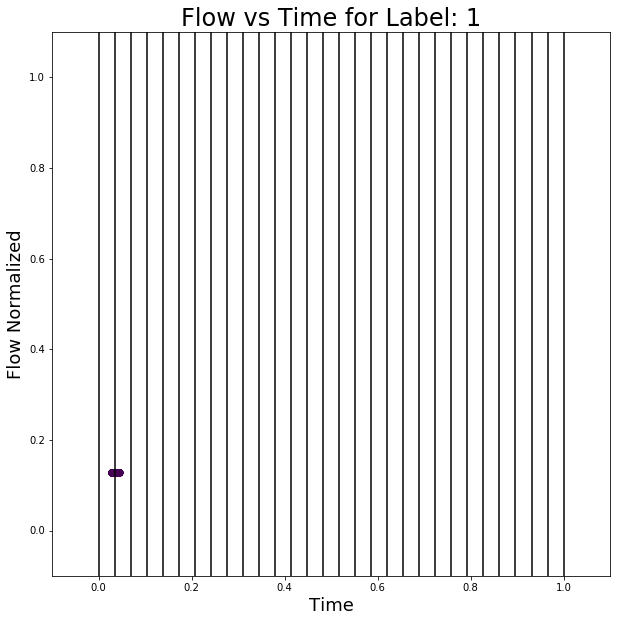

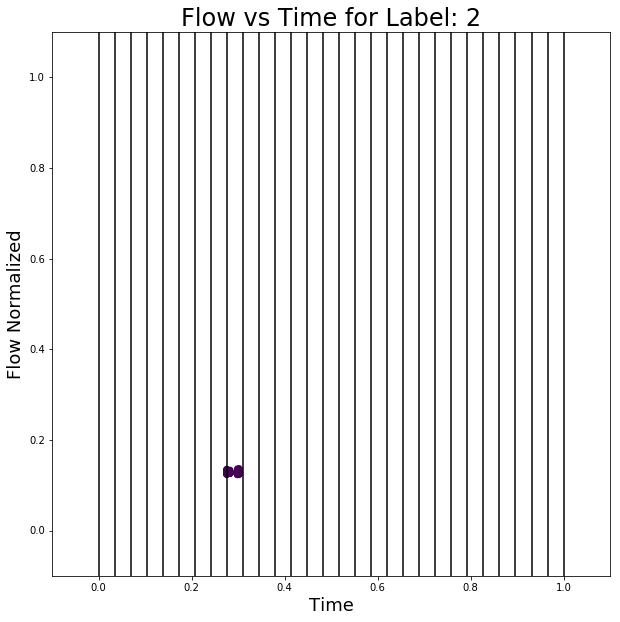

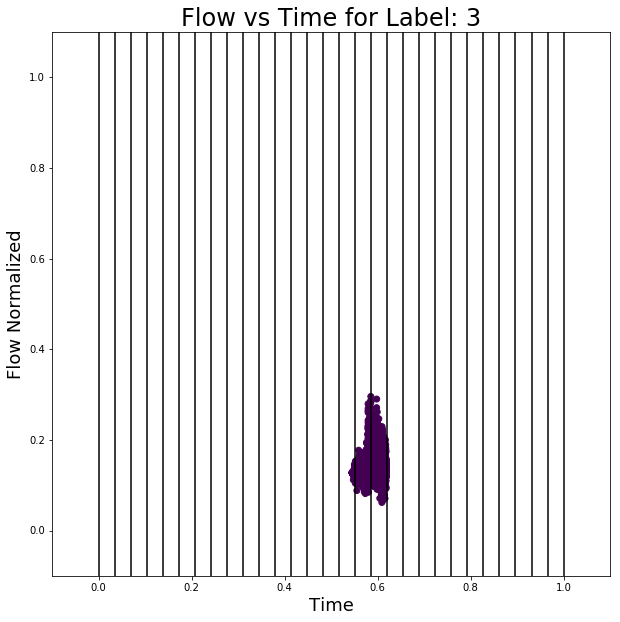

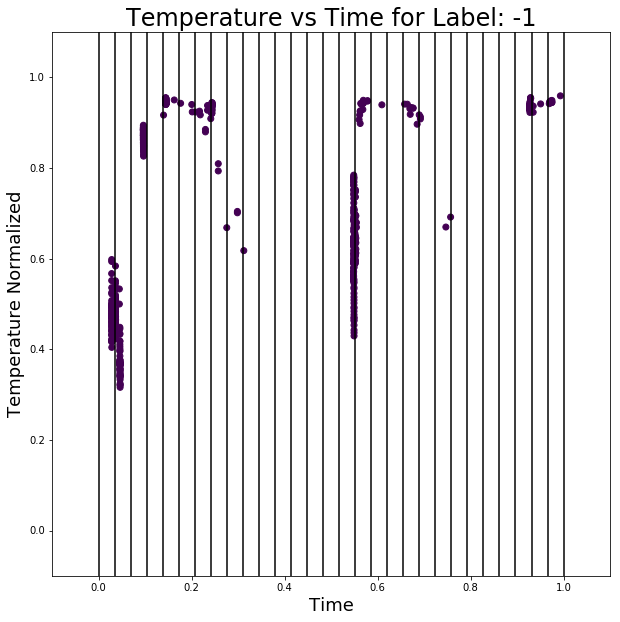

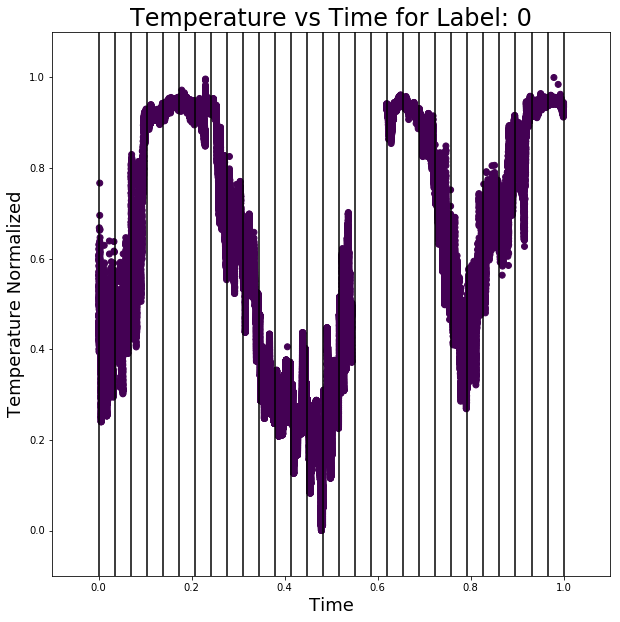

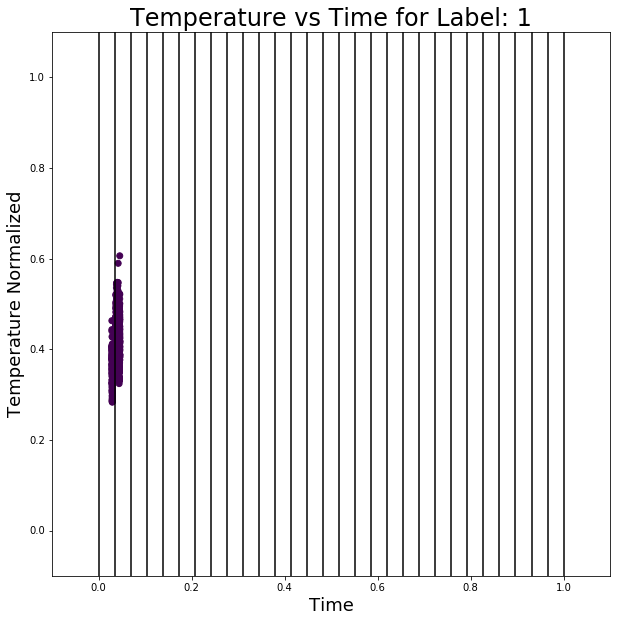

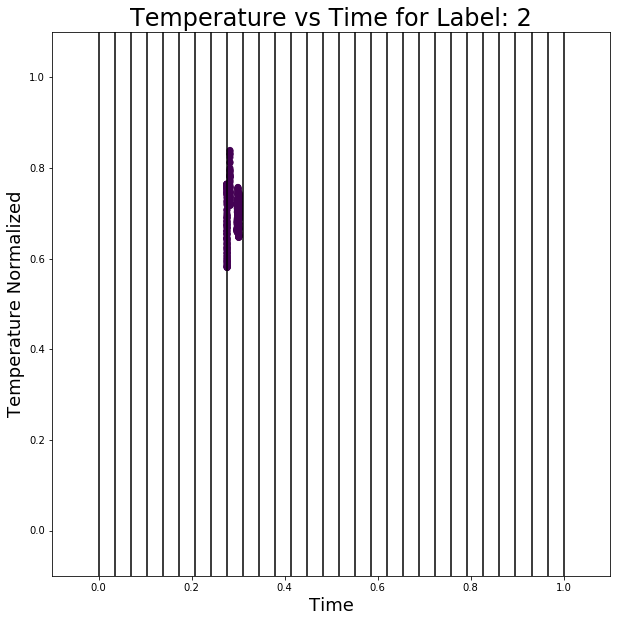

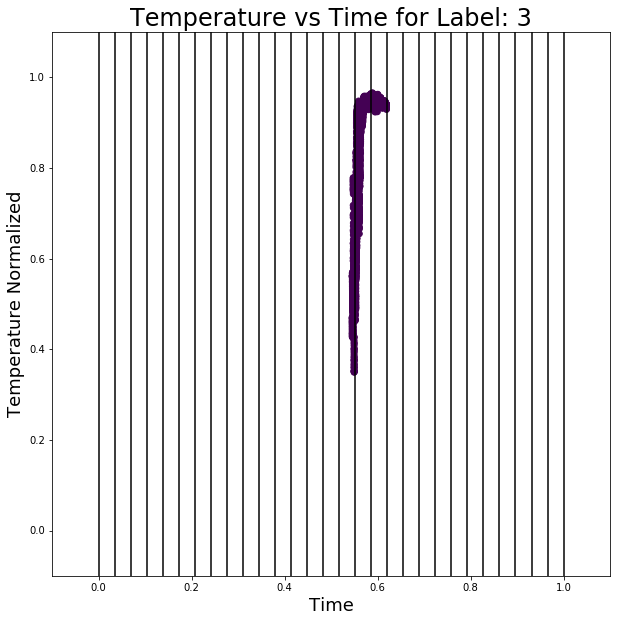

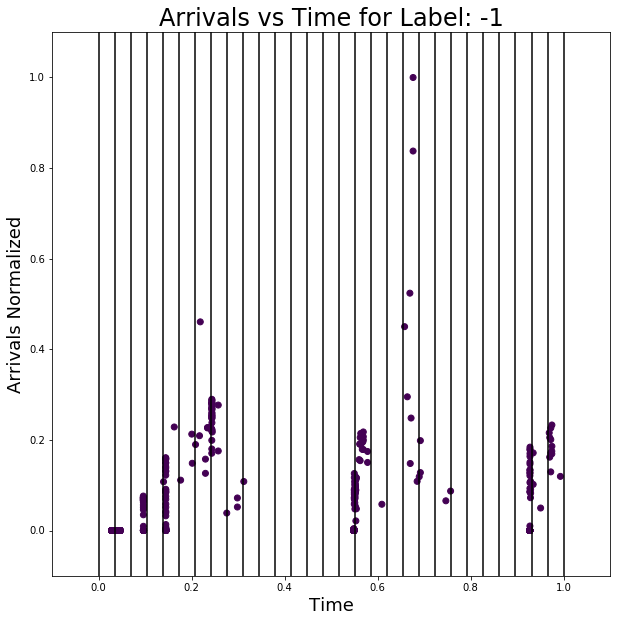

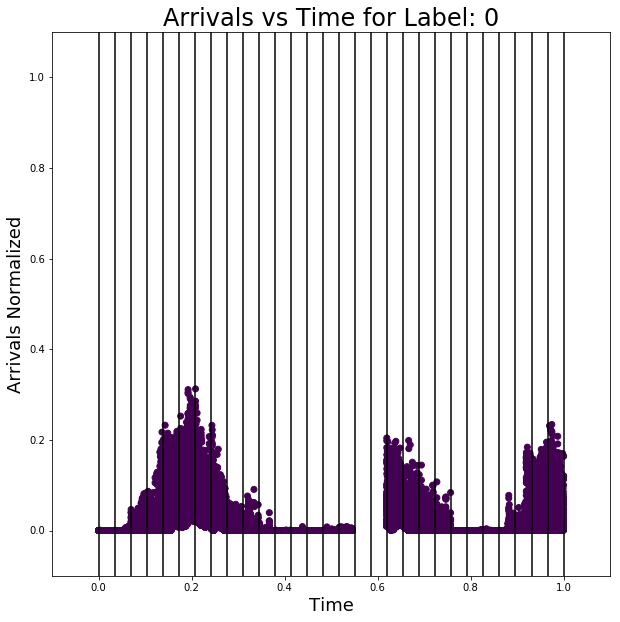

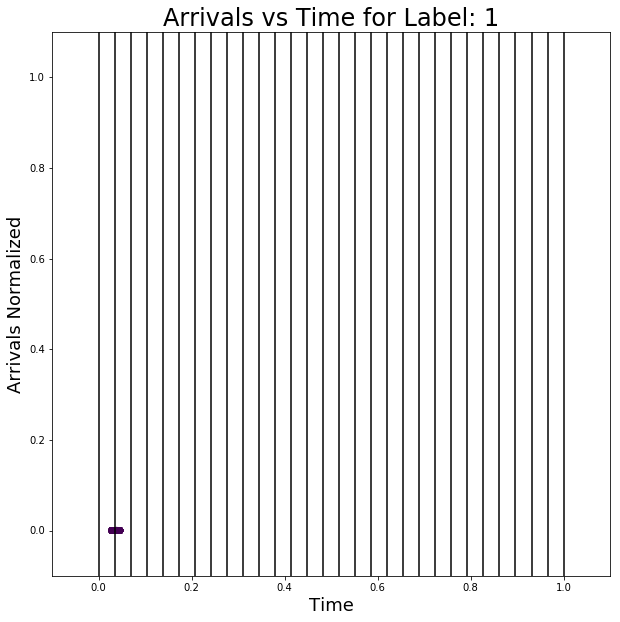

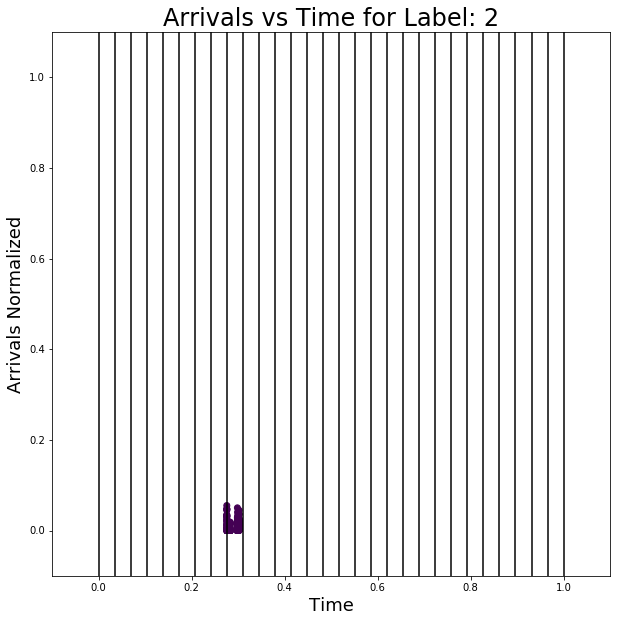

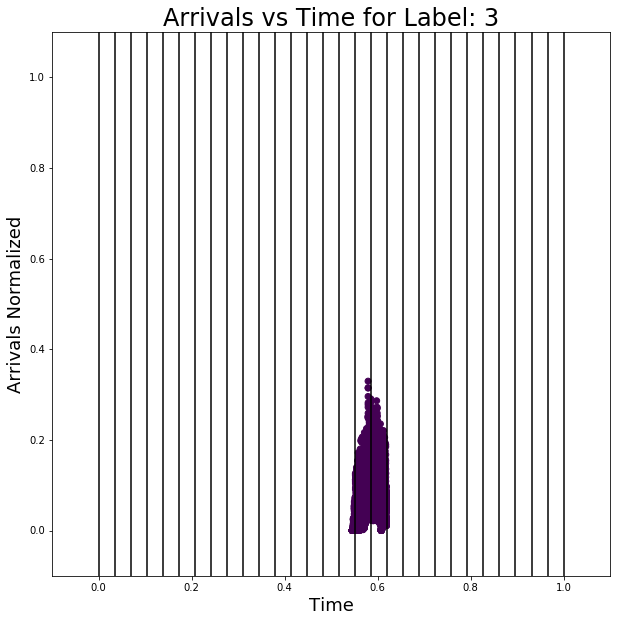

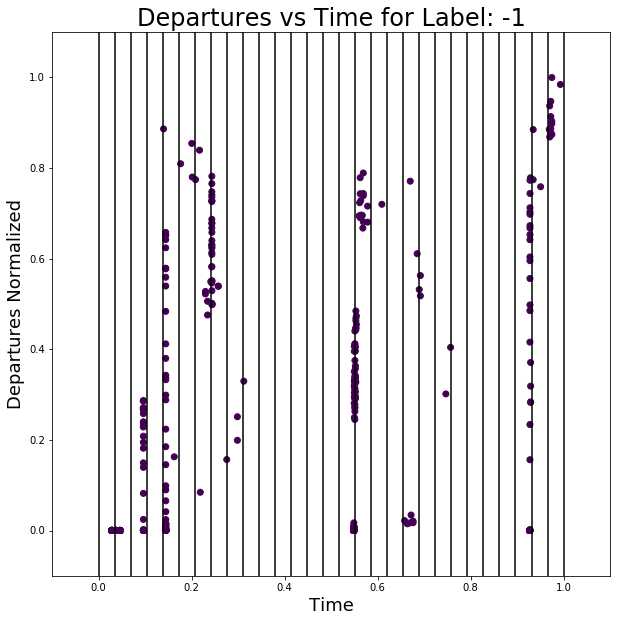

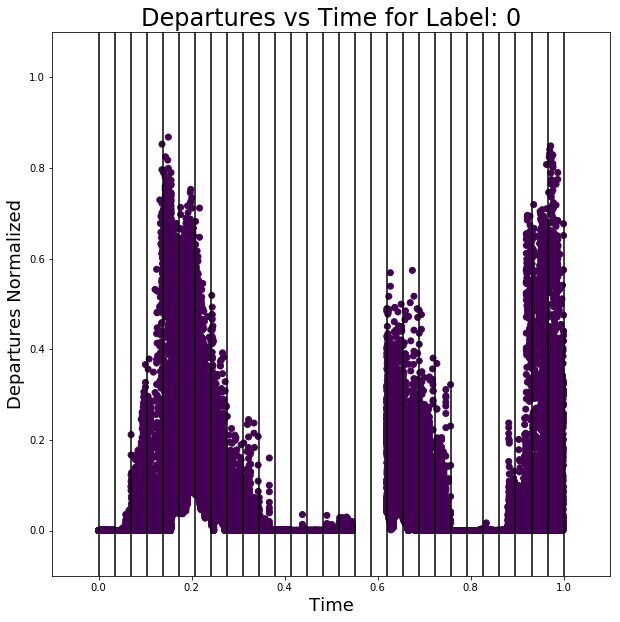

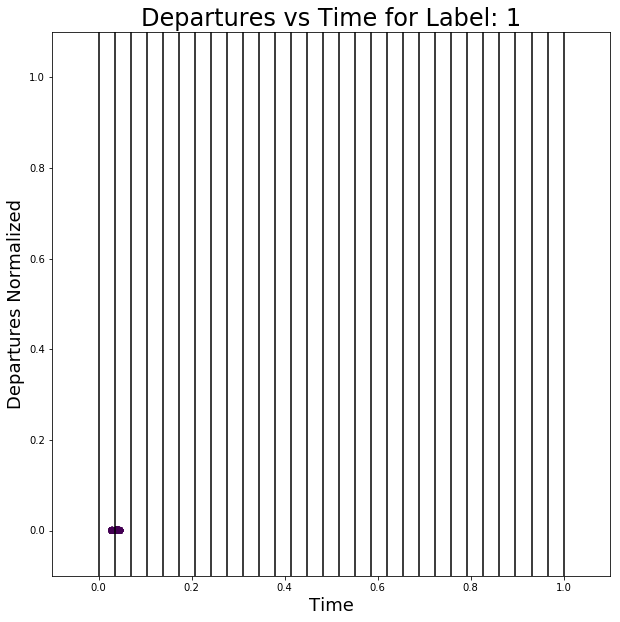

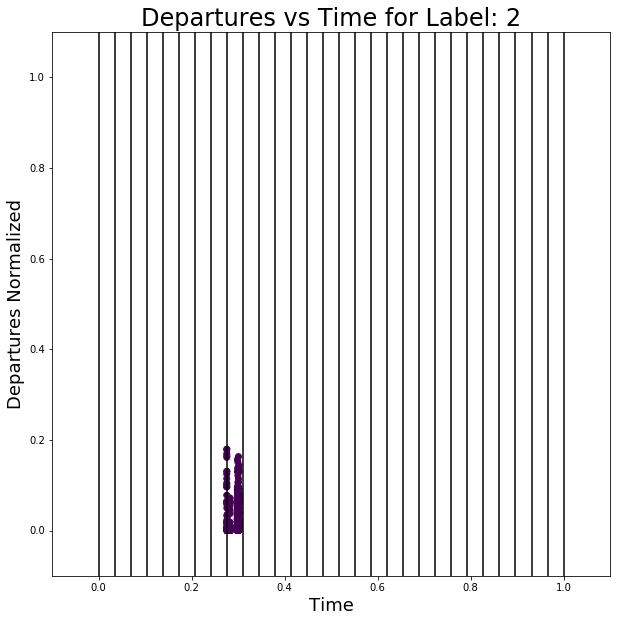

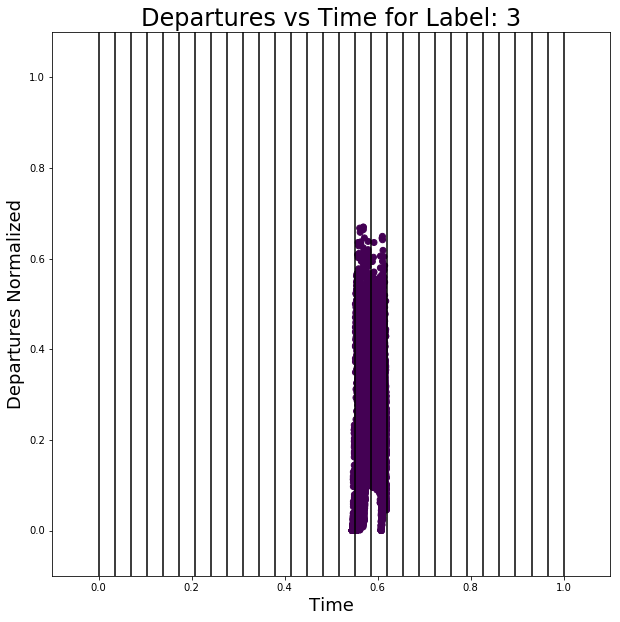

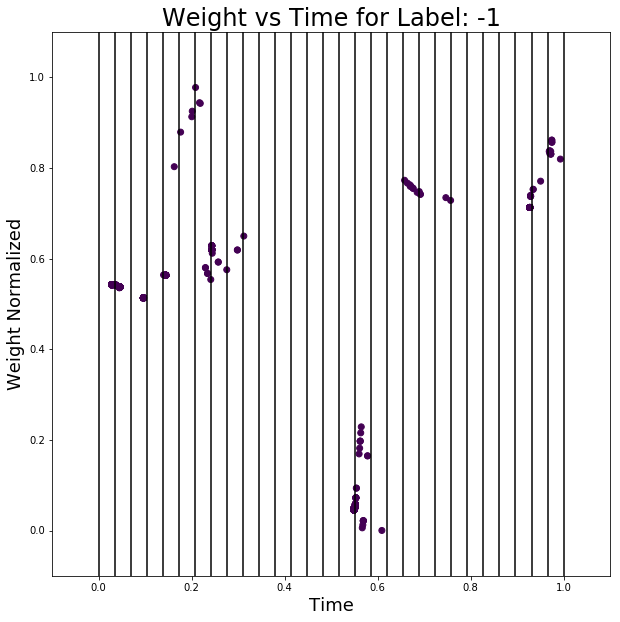

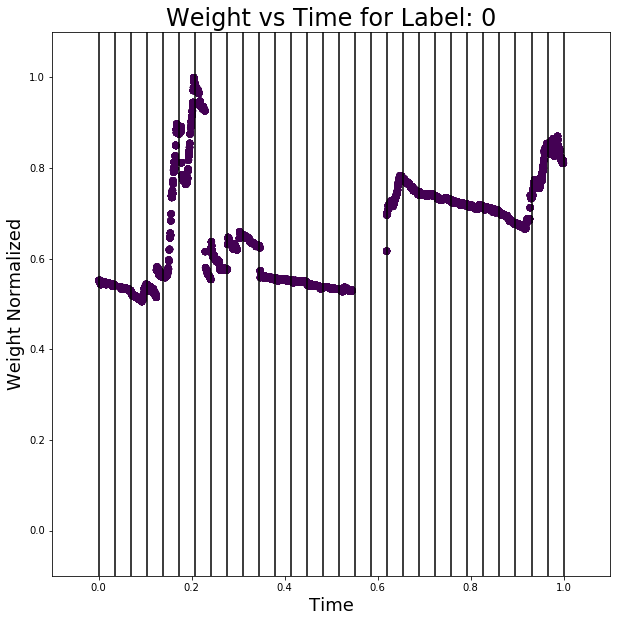

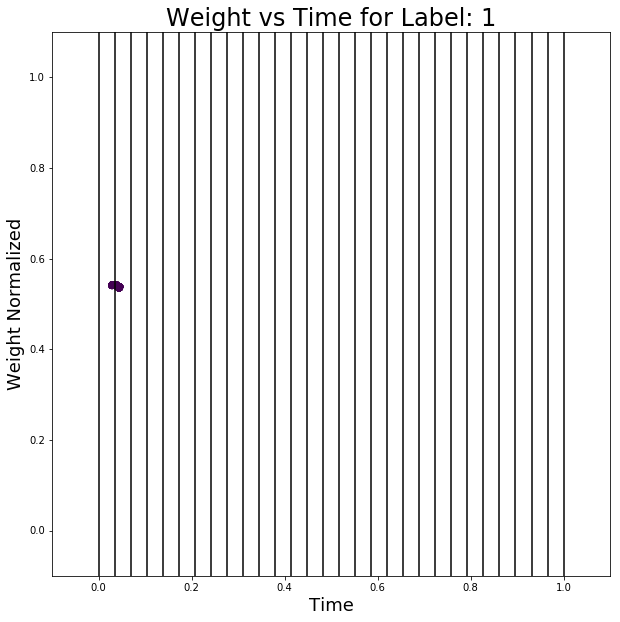

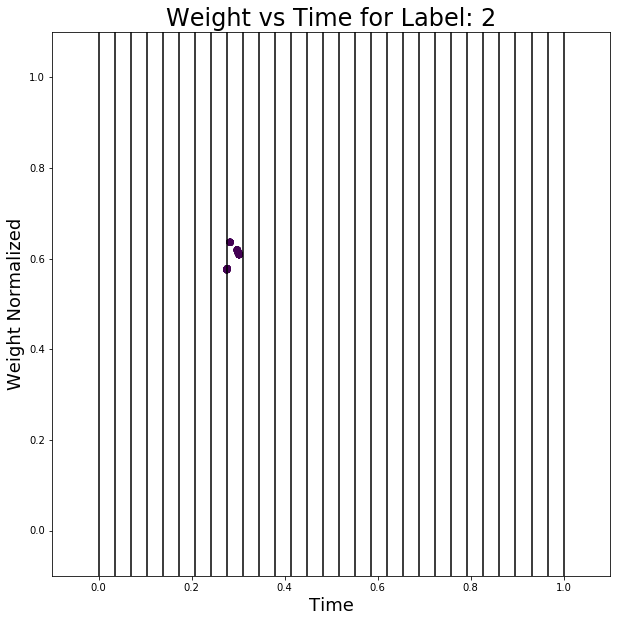

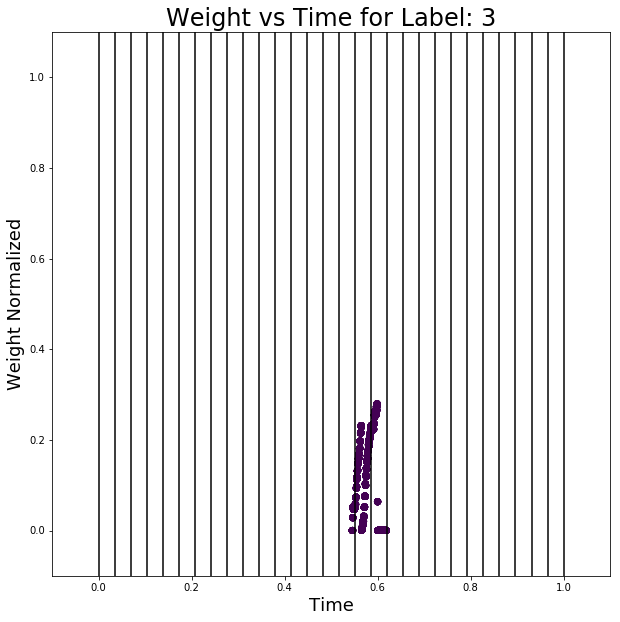

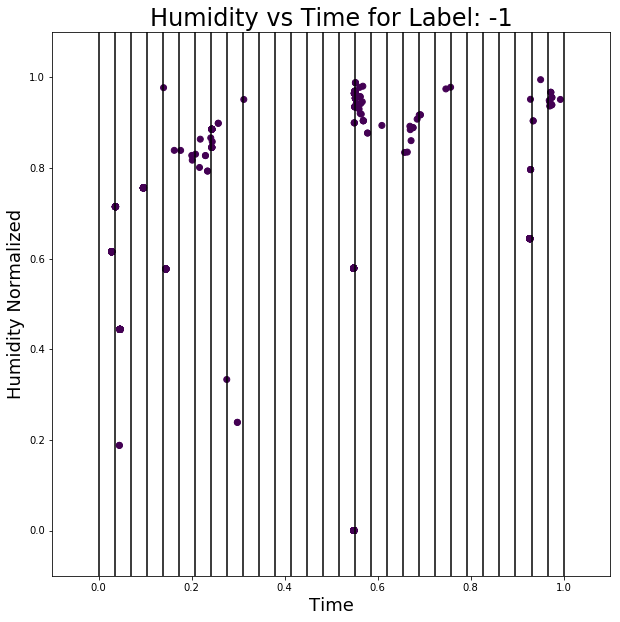

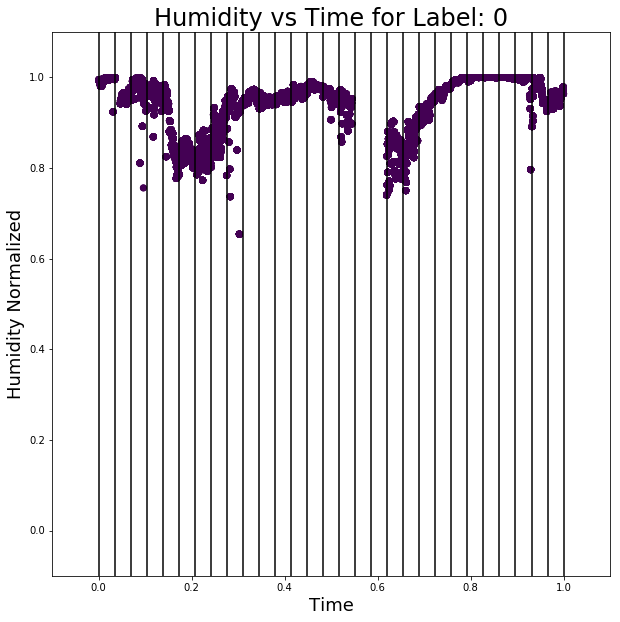

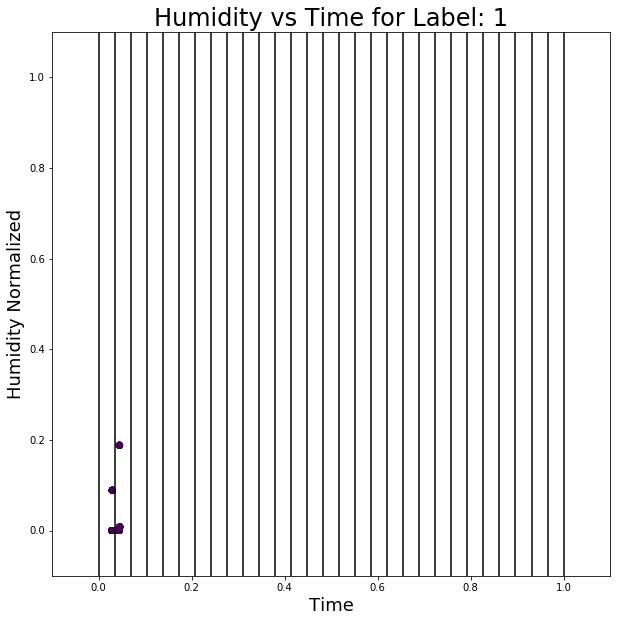

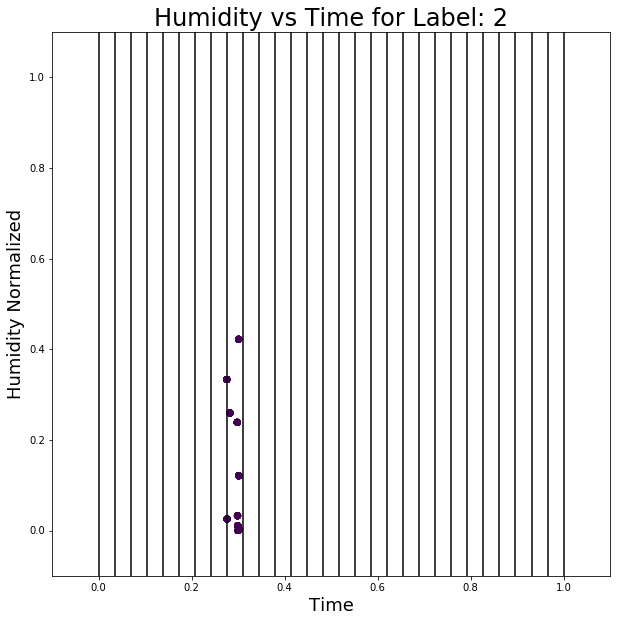

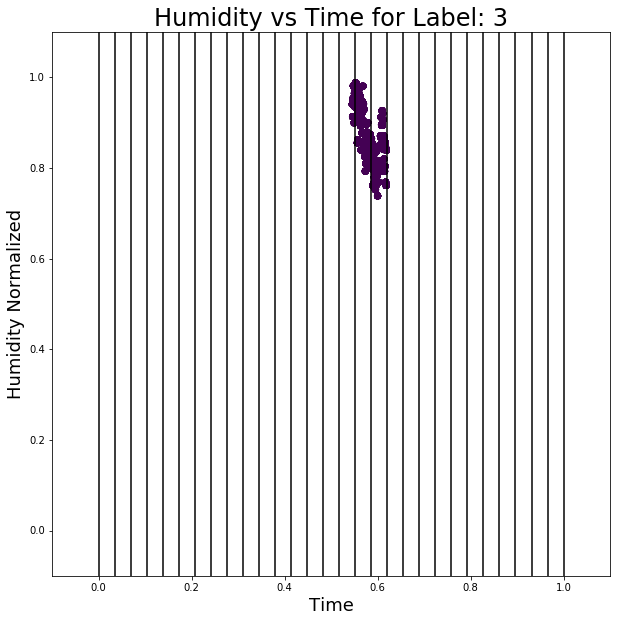

In [8]:
#Graph each attribute per label
for attribute, column in [['Flow', 6], ['Temperature', 5], ['Arrivals', 4], ['Departures', 3], ['Weight', 2], ['Humidity', 1]]:
    for label in range(-1, clusters):
        plt.figure(figsize=(10,10))
        indexes = [index for index, lbl in enumerate(labels) if lbl == label]
        plt.title(f'{attribute} vs Time for Label: {label}', fontsize=24)
        plt.ylabel(f'{attribute} Normalized', fontsize=18)
        plt.xlabel('Time', fontsize=18)
        for i in range(30):
            plt.axvline(x=i/29, c='black')
        plt.xlim(right=1.1)
        plt.xlim(left=-0.1)
        plt.ylim(top=1.1)
        plt.ylim(bottom=-0.1)
        plt.scatter(timestamps[indexes], X[:,column][indexes], c=labels[indexes])

Out of curiosity, we are going to create a predictive model that will take in all the features except for flow (temperature, arrival, departures, weight, humidity) and attempt to predict flow. Let's start with getting the training data and the testing data.

In [13]:
#Create a numpy array to store our features in
data = np.array([
    clean_data['flow'].values,
    clean_data['temperature'].values,
    clean_data['arrivals'].values,
    clean_data['departures'].values,
    clean_data['weight'].values,
    clean_data['humidity'].values
])

#Save true labels
true_labels = data[:,-1]

#Rotate array so that each row is an entry of features from each attribute
data = np.rot90(data, k=-1)

#Normalize using Min Max Scaler
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

#Split features and labels
labels = data[:,-1]
features = data[:,:6]

#Split data and lebels into training and testing 
training_data, testing_data, training_labels, testing_labels = train_test_split(features, labels, test_size=0.1, train_size=0.9, shuffle=True)

#Encode labels
training_label_encoder = preprocessing.LabelEncoder()
training_label_encoder.fit(training_labels)
encoded_training_labels = training_label_encoder.transform(training_labels)

Now we will use a KNN Classifier in order to try and predict flow. We will check its accruacy with different error rates. Note that we can justify using normalized values because if we dont we get divide by 0 errors and get a ton of nan values.

In [14]:
#Build model
model = KNeighborsClassifier(n_neighbors=1)

#Fit data
model.fit(training_data, encoded_training_labels)

#Get encoded predictions
encoded_predictions = model.predict(testing_data)
decoded_predictions = training_label_encoder.inverse_transform(encoded_predictions)

#Check accuracy of model
#Note we will allow an error of _%
errors = np.absolute((testing_labels-decoded_predictions)/testing_labels)
for error in [err for err in range(1,11)]:
    accuracy = len(errors[np.where(errors < error/100)])/len(errors)
    print(f'{error}% error has accuracy of {accuracy}')

1% error has accuracy of 0.7798066595059077
2% error has accuracy of 0.8721804511278195
3% error has accuracy of 0.92218641842702
4% error has accuracy of 0.9514261845088913
5% error has accuracy of 0.9670605084138919
6% error has accuracy of 0.9793531447666786
7% error has accuracy of 0.9862752118391216
8% error has accuracy of 0.9910490511994271
9% error has accuracy of 0.993077932927557
10% error has accuracy of 0.9940327007996181
